# Initialize

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import sklearn.preprocessing as preprocessing
from sklearn.pipeline import make_pipeline
import seaborn as sns
from math import sqrt, log

# Import data

In [2]:
data_path = "../data/raw/training.csv"
data = pd.read_csv(data_path)
# set EventId as index
data.set_index("EventId", inplace=True)

## Inspect data for missing values

In [3]:
# A value is missing if it is equal to -999.0
data.replace(-999.0, np.nan, inplace=True)
# Check for missing values by raising a warning if any are found
if data.isnull().sum().any():
    print("Warning: Missing values found!")
else:
    print("No missing values found.")

In [6]:
# Count number of missing values per column
missing_values = data.isnull().sum()
missing_values_percentage = (missing_values / len(data)) * 100
# Print columns with missing values and their percentages
for col, perc in missing_values_percentage.items():
    if perc > 0:
        print(f"Column: {col}, Missing Values: {perc:.2f}%")

Column: DER_mass_MMC, Missing Values: 15.25%
Column: DER_deltaeta_jet_jet, Missing Values: 70.98%
Column: DER_mass_jet_jet, Missing Values: 70.98%
Column: DER_prodeta_jet_jet, Missing Values: 70.98%
Column: DER_lep_eta_centrality, Missing Values: 70.98%
Column: PRI_jet_leading_pt, Missing Values: 39.97%
Column: PRI_jet_leading_eta, Missing Values: 39.97%
Column: PRI_jet_leading_phi, Missing Values: 39.97%
Column: PRI_jet_subleading_pt, Missing Values: 70.98%
Column: PRI_jet_subleading_eta, Missing Values: 70.98%
Column: PRI_jet_subleading_phi, Missing Values: 70.98%


In [7]:
# Drop rows with any missing values
data_clean = data.dropna()
# data.replace(np.nan, -999.0, inplace=True)

# Visualize data distributions

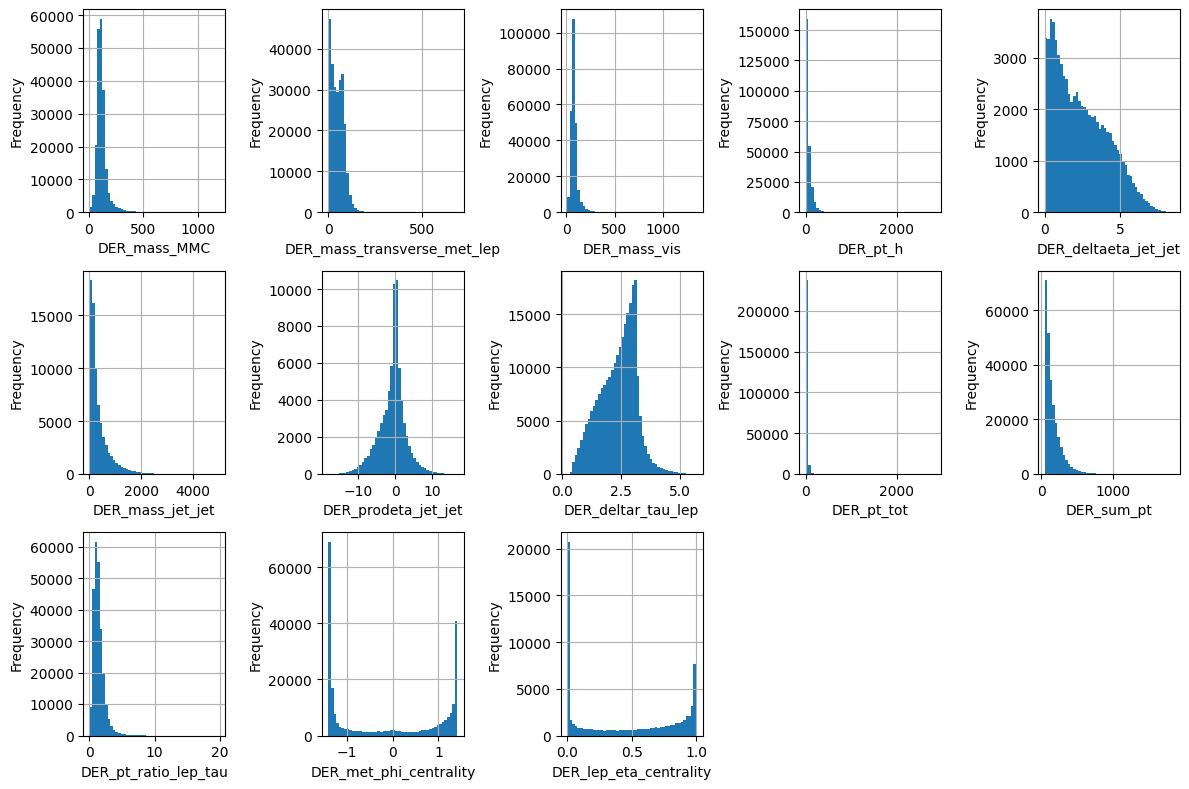

In [21]:
# Plot distributions of each column in data in one figure
der_columns = data.columns[np.strings.startswith(np.array(data.columns, dtype=str), "DER_")]
plt.figure(figsize=(12, 8))
for i, column in enumerate(der_columns):
    plt.subplot(3, 5, i + 1)
    data[column].hist(bins=50)
    # plt.title(column)
    plt.xlabel(column)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

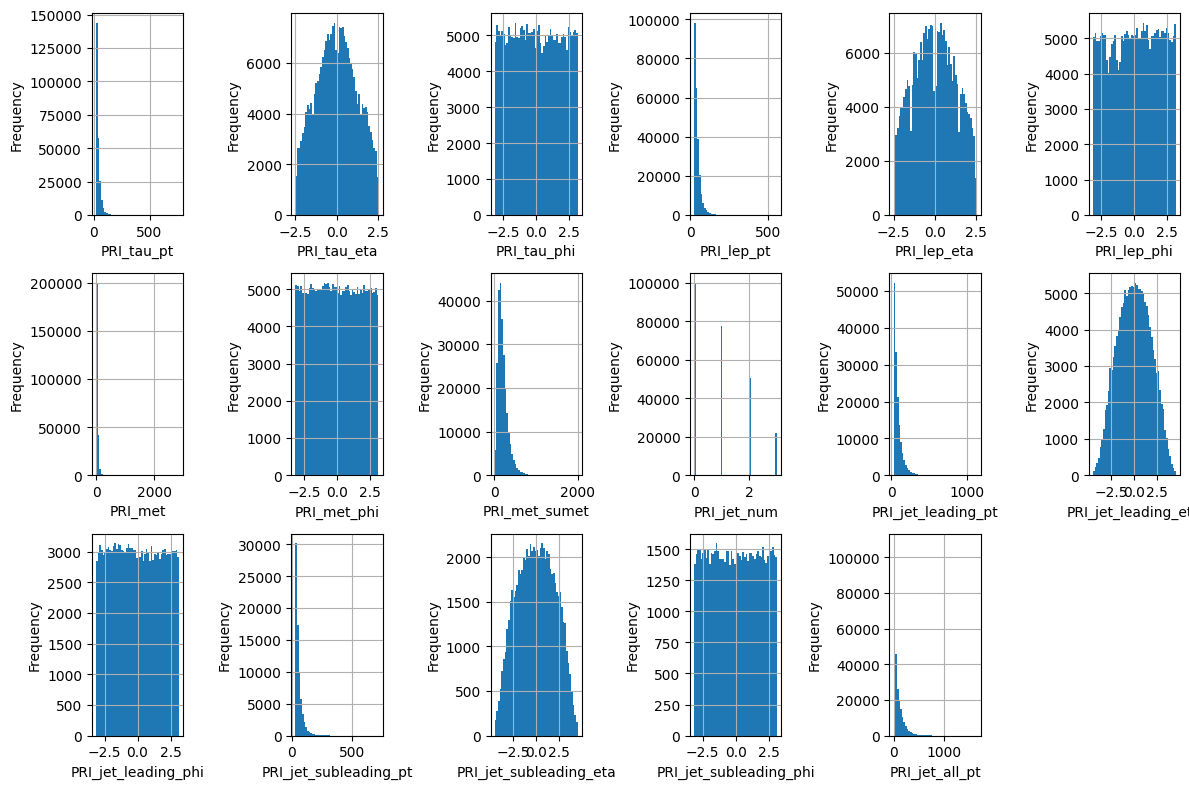

In [22]:
# Plot distributions of each column in data in one figure
pri_columns = data.columns[np.strings.startswith(np.array(data.columns, dtype=str), "PRI_")]
plt.figure(figsize=(12, 8))
for i, column in enumerate(pri_columns):
    plt.subplot(3, 6, i + 1)
    data[column].hist(bins=50)
    # plt.title(column)
    plt.xlabel(column)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

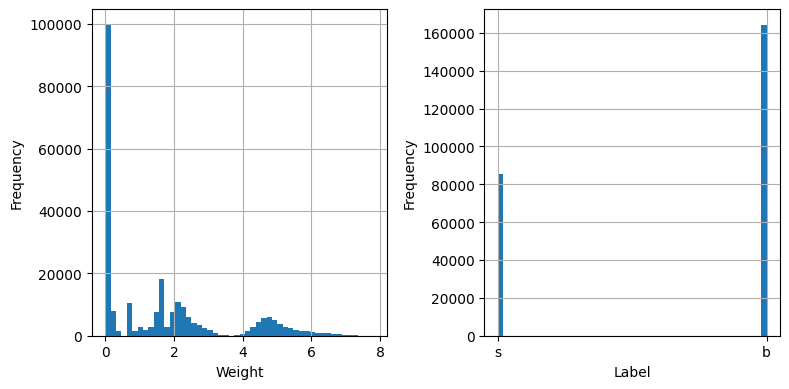

In [33]:
# Plot distributions of each column in data in one figure
other_columns = data.columns[
    ~np.strings.startswith(np.array(data.columns, dtype=str), "PRI_")
    & ~np.strings.startswith(np.array(data.columns, dtype=str), "DER_")
]
plt.figure(figsize=(8, 4))
for i, column in enumerate(other_columns):
    plt.subplot(1, 2, i + 1)
    data[column].hist(bins=50)
    # plt.title(column)
    plt.xlabel(column)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Resampling technique

In [ ]:
# Split into traning and test sets on all data
data_split = data.drop(["Weight"], axis=1)
label = data[["Label"]]
# Drop labels from X
data_split = data_split.drop(["Label"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(data_split, label, test_size=0.2, random_state=42)
y_train = y_train["Label"]
y_test = y_test["Label"]

In [13]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Basic Logistic regression model

In [ ]:
# Train a logistic regression model on the training set and evaluate on the test set
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7503360872115761
Classification Report:
               precision    recall  f1-score   support

           b       0.78      0.86      0.82    107783
           s       0.67      0.53      0.59     55865

    accuracy                           0.75    163648
   macro avg       0.72      0.70      0.71    163648
weighted avg       0.74      0.75      0.74    163648



In [ ]:
# Train a logistic regression model on the training set and evaluate on the test set (Clean data)
model_clean = LogisticRegression()
model_clean.fit(X_train_clean_scaled, y_train_clean)

y_pred_clean = model_clean.predict(X_test_clean_scaled)

print("Accuracy of clean model:", accuracy_score(y_test_clean, y_pred_clean))
print("Classification Report:\n", classification_report(y_test_clean, y_pred_clean))

Accuracy of clean model: 0.7279883707927989
Classification Report:
               precision    recall  f1-score   support

           b       0.73      0.77      0.75     23658
           s       0.72      0.68      0.70     21057

    accuracy                           0.73     44715
   macro avg       0.73      0.73      0.73     44715
weighted avg       0.73      0.73      0.73     44715



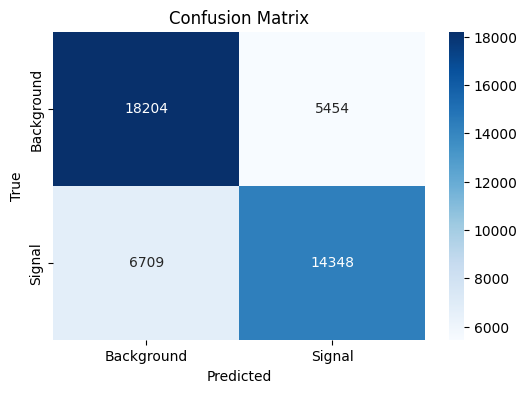

In [ ]:
# Make confusion matrix
cm = confusion_matrix(y_test_clean, y_pred_clean)
true_positives = cm[1, 1]
false_positives = cm[0, 1]
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Background", "Signal"], yticklabels=["Background", "Signal"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def ams_score(y_true, y_pred, weights, br=10.0):
    """
    Compute the Approximate Median Significance (AMS) metric.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True binary labels, where 1 or 's' indicates signal, 0 or 'b' indicates background.
    y_pred : array-like of shape (n_samples,)
        Predicted binary labels (same encoding as y_true).
    weights : array-like of shape (n_samples,)
        Event weights for each observation.
    br : float, default=10.0
        Regularization term (background regularization constant).

    Returns
    -------
    ams : float
        The AMS metric value.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    weights = np.asarray(weights)

    # Compute s (weighted true positives) and b (weighted false positives)
    s = np.sum(weights[(y_true == "s") & (y_pred == "s")])
    b = np.sum(weights[(y_true == "b") & (y_pred == "s")])

    # Avoid division by zero
    if b + br <= 0:
        return 0.0

    # Compute AMS according to formula
    radicand = 2 * ((s + b + br) * np.log(1.0 + s / (b + br)) - s)
    return np.sqrt(radicand) if radicand > 0 else 0.0

In [ ]:
ams = ams_score(y_test_clean, y_pred_clean, weights_clean)
print("AMS Score:", ams)

AMS Score: 0.40552094644229014
